# Get nltk set-up

Run the following script before everything else so all dependencies are ready and nltk is installed.

In [1]:
import re
import pandas as pd
import sys
from cleantext import clean
import nltk
from nltk.corpus import stopwords
import ssl

def initialize_nltk():
    """Initialize NLTK resources if they don't exist."""
    try:
        # Check if resources are already downloaded
        nltk.data.find('tokenizers/punkt')
        nltk.data.find('corpora/wordnet')
        nltk.data.find('corpora/omw-1.4')
        nltk.data.find('corpora/stopwords')
    except LookupError:
        # Only download if resources are missing
        try:
            _create_unverified_https_context = ssl._create_unverified_context
            ssl._create_default_https_context = _create_unverified_https_context
        except AttributeError:
            pass
        
        nltk.download('punkt', quiet=True)
        nltk.download('wordnet', quiet=True)
        nltk.download('omw-1.4', quiet=True)
        nltk.download('stopwords', quiet=True)

# Initialize NLTK resources
initialize_nltk()

# Clean text

When ready, this should clean the long csv file, assuming it is in the same directory as this script. This takes about an hour.

In [ ]:
'''
This function will clear stop words, assuming the text has been cleaned.
'''
date_patterns = re.compile(
    r'\b(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\.?\s+\d+,?\s+\d+\b|'
    r'\b(?:January|February|March|April|May|June|July|August|September|October|November|December)\s+\d+,?\s+\d+\b|'
    r'(\d+)-(\d+)-(\d+) ?(\d*):?(\d*):?(\d*)(\.\d+)?'
)

def clean_column(text):
    if not isinstance(text, str):
        return text
    
    text = text.lower()
    text = re.sub(date_patterns, ' <DATE> ', text)

    text = clean(text,
            fix_unicode=True,
            to_ascii=True, 
            no_punct=True,
            no_urls=True,                  
            no_emails=True,                
            no_numbers=True,  
            replace_with_punct= "",             
            no_line_breaks=True,
            replace_with_url=" <URL> ",
            replace_with_email=" <EMAIL> ",
            replace_with_number=" <NUMBER> ",
            lower=True
            )
    return text

def clean_df(df):
    """Process the entire DataFrame."""
    df['content'] = df['content'].apply(clean_column)
    return df

df_chunks = pd.read_csv('995,000_rows.csv', usecols=['content'], chunksize=10000)
with open('995,000_clean.csv', 'w', encoding='utf-8') as f:
    for chunk in df_chunks:
        processed_chunk = clean_df(chunk)
        processed_chunk.to_csv(f, index=False, header=f.tell()==0)

print(f"Cleaned data saved to '995,00_clean'.csv'")

Cleaned data saved to 'cleaned_text.csv'


# Process text

The following script will both remove stop words as well as stem the text. As well, there will be text files made with the 10,000 most frequently used words both after removing stopwords and after stemming. This takes the longest, about 1 hour and 45 minutes to run, but the text files with the most frequently used words are pushed to the GitHub.

In [ ]:
import re
import pandas as pd
import sys
from cleantext import clean
import nltk
from nltk.corpus import stopwords
import ssl
from collections import Counter

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

'''
This function will remove stopwords from the text
'''
stop_words = set(stopwords.words('english'))
stemmer = nltk.stem.PorterStemmer()

stopword_freq = Counter()
stemmed_freq = Counter()

def processtext(text):
    if not isinstance(text, str):
        return text
    
    tokens = nltk.word_tokenize(text)
    processed_tokens = []
    for word in tokens:
        if word.lower() not in stop_words:
            if word in ['<', '>']:
                continue
            if word in ['date', 'url', 'number', 'email']:
                continue
            if len(word) == 1:
                continue

            # Count word frequency after stopword removal
            stopword_freq[word.lower()] += 1

            # Stem and count frequency after stemming
            stemmed_word = stemmer.stem(word)
            stemmed_freq[stemmed_word.lower()] += 1
            processed_tokens.append(stemmed_word)

    return ' '.join(processed_tokens)

def process_df(df):
    """Process the entire DataFrame."""
    df['content'] = df['content'].apply(processtext)
    return df

df_chunks = pd.read_csv('995,000_clean.csv', usecols=['content'], chunksize=10000)

with open('Processed_995,000.csv', 'w', encoding='utf-8') as f:
    for chunk in df_chunks:
        processed_chunk = process_df(chunk)
        processed_chunk.to_csv(f, index=False, header=f.tell()==0)

with open('stopword_freq.txt', 'w', encoding='utf-8') as f:
    for word, freq in stopword_freq.most_common(10000):  # Top 10 most frequent words after stopword removal
        f.write(f"{word}: {freq}\n")

with open('stemmed_freq.txt', 'w', encoding='utf-8') as f:
    for word, freq in stemmed_freq.most_common(10000):  # Top 10 most frequent stemmed words
        f.write(f"{word}: {freq}\n")

print(f"Cleaned data saved to '995,000_processed.csv'")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Cleaned data saved to '995,000_processed.csv'


# Count words

This script takes a long time because of tokenizing, so it takes about 1 hour and 30 minutes, but the result you should get is saved below in a markdown comment, so no need to run it a second time. However, I am looking into huggingface, since it has fast tokenizing and data storing libraries, since I can see from online forums that nltk and pandas are relatively slow, especially pandas. However, for now, pandas and nltk work fine, they are just time consuming.

In [30]:
import pandas as pd
import nltk

'''
This function will count the number of words in the text
'''
i = 0
def countwords(text):
    if not isinstance(text, str):
        return 0 
    words = nltk.word_tokenize(text)
    return len(words)
    
def print_wordcount(file_path):
    word_count = 0
    df_chunks = pd.read_csv(file_path, usecols=['content'], chunksize=10000)
    for chunk in df_chunks:
        word_count += chunk['content'].apply(countwords).sum()
    print(f"Word count for {file_path} is {word_count}")

print_wordcount('995,000_rows.csv')
print_wordcount('995,000_clean.csv')
print_wordcount('Processed_995,000.csv')

Word count for 995,000_rows.csv is 541899775
Word count for 995,000_clean.csv is 482213509
Word count for Processed_995,000.csv is 263466765


Word count for 995,000_rows.csv is 541899775

Word count for 995,000_clean.csv is 482213509

Word count for Processed_995,000.csv is 263466765

# Graphs

Lastly, when all the above scripts are run, the following script will plot the most frequently used words for removing stop words and after stemming. I have chosen to take the logarithm for the frequency values so as to reduce the curve. 

It could also be beneficial to store the most used words in the cleaned and original data sets, but I haven't done this yet, and this will also be a time consuimg process (hence the idea of using hugging face).

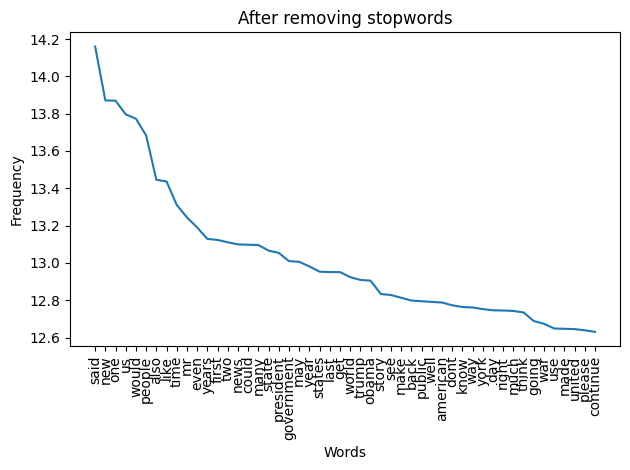

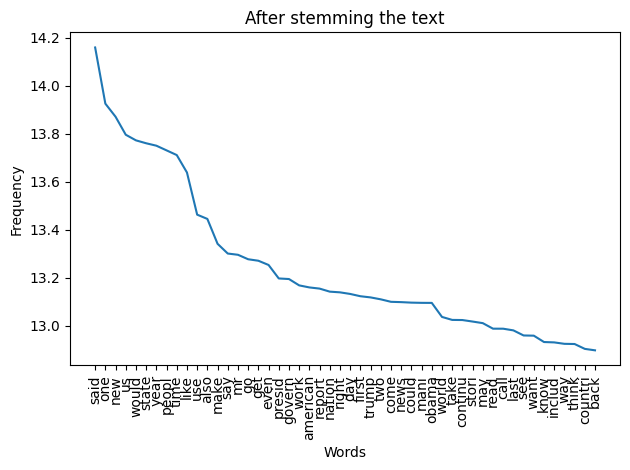

In [ ]:
import matplotlib.pyplot as plt
import math

def txt_to_dict(file_path):
    freq_dict = {}
    with open(file_path) as f:
        for line in f:
            word, freq = line.strip().split(': ')
            freq_dict[word] = int(freq)
    return freq_dict

stopword_freq = txt_to_dict('stopword_freq.txt')
stemmed_freq = txt_to_dict('stemmed_freq.txt')

def graph_frequency(data, caption):

    frequencies = [math.log(x) for x in list(data.values())[:50]]
    items = list(data.keys())[:50]

    fig, ax = plt.subplots()
    ax.plot(items, frequencies)
    ax.set_xlabel('Words')
    ax.set_ylabel('Frequency')
    ax.set_title(caption)
    ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

graph_frequency(stopword_freq, "After removing stopwords")
graph_frequency(stemmed_freq, "After stemming the text")